In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Synthetic data

Open some standard training data

In [2]:
mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'hdc'
bin_size = 160
single_spikes = False

data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

units:  85  hdc units:  22


In [3]:
dataset_dict

{'name': 'th1-Mouse12-120806-wake-hdc',
 'covariates': {'hd': array([3.57467446, 3.80964147, 4.14341321, ..., 4.84318773, 4.82596932,
         4.84272391]),
  'omega': array([ 1.46854381,  2.08607334, -1.20485309, ..., -0.10761507,
          0.10471615,  0.10471615]),
  'speed': array([14.39275196, 13.94361726, 16.51488074, ...,  0.48187431,
          0.15617911,  0.15617911]),
  'x': array([77.39538791, 76.18143564, 75.27406334, ..., 45.73409944,
         45.81119933, 45.78621067]),
  'y': array([63.80116344, 61.84427985, 59.80615774, ..., 63.061873  ,
         63.061873  , 63.061873  ]),
  'time': array([0.00000e+00, 1.60000e-01, 3.20000e-01, ..., 2.18816e+03,
         2.18832e+03, 2.18848e+03])},
 'spiketrains': array([[ 0.,  2.,  0., ...,  1.,  1.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 9.,  3.,  2., ...,  2.,  3.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [16.,  6.,  0., ...,  2.,  0.,

### Create a synthetic dataset with neurons with Gaussian-like head direction tuning curves and Poisson SCDs.

In [4]:
T = dataset_dict['tbin']

def rate(s, s_preffered = np.pi, sigma=np.pi/4, r_max = 10):
    """Rate tuning curve will look like a Gaussian"""
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) + 1

def rate_circular(s, s_preffered = np.pi, sigma=np.pi/4, r_max = 10):
    """Rate tuning curve will look like circular wrapped Gaussian"""
    sum = 0
    for k in [-1,0,1]:
        sum += np.exp(-0.5 * (s - s_preffered + 2*np.pi*k)**2 / sigma**2)
    return r_max * sum + 1


In [5]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-data'
synthetic_data['covariates'] = {'hd': dataset_dict['covariates']['hd'],
                                'time': dataset_dict['covariates']['time']}
synthetic_data['spiketrains'] = []

hd = synthetic_data['covariates']['hd']

neurons = 5
preferred_directions = np.linspace(0, 2*np.pi, neurons)
for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        r_t = rate_circular(hd[t], s_preffered=preferred_directions[n])
        spiketrain.append(np.random.poisson(lam=r_t*T))
    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

In [6]:
np.savez_compressed(data_dir+'/synthetic_poisson', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

In [7]:
data = HDC.get_synthetic_data('synthetic_poisson', data_dir)

### Recover tuning curves through histograms

Text(0, 0.5, 'Firing rate [Hz]')

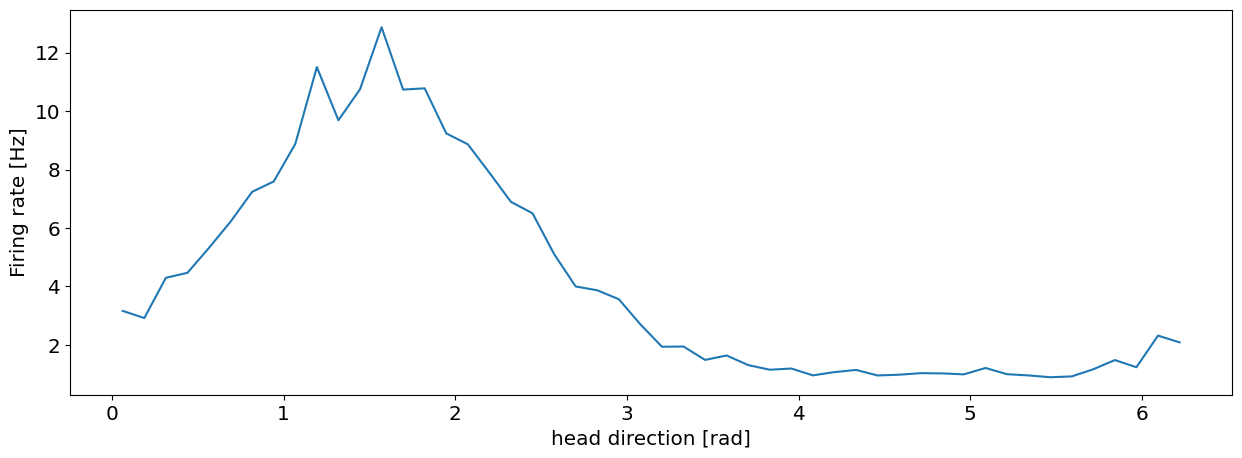

In [13]:
ne = 1

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)
plt.plot((bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
plt.xlabel('head direction [rad]')
plt.ylabel('Firing rate [Hz]')


# Load a trained model

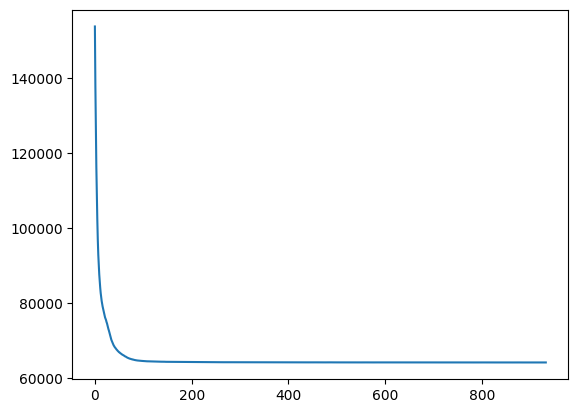

In [9]:
dataset_dict = HDC.get_synthetic_data('synthetic_poisson', data_dir)
model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run=-1

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

#ll = lib.helper.RG_pred_ll(
#    modelfit, validation_set, neuron_group=None, ll_mode='MC', 
#    ll_samples=1, cov_samples=1, beta=0.0
#)

plt.plot(training_results['training_loss'])

In [10]:

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = hd_sweep[None, None, :, None]

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

print(P_mc.shape)

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

torch.Size([30, 5, 100, 9])


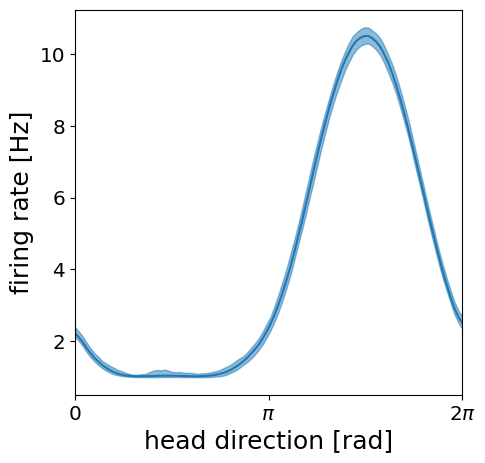

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update(params)

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 3  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate [Hz]', fontsize=18)
ax.set_xlabel('head direction [rad]', fontsize=18)
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()